In [2]:
import sys
sys.path.append('../..')
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import matplotlib.pyplot as plt
import ta
import numpy as np
import datetime
from IPython.display import clear_output
from utilities.data_manager import ExchangeDataManager
from utilities.custom_indicators import get_n_columns
from utilities.bt_analysis import get_metrics, backtest_analysis
from utilities.plot_analysis import plot_equity_vs_asset, plot_futur_simulations, plot_bar_by_month
import nest_asyncio
nest_asyncio.apply()

C:\Users\simon\AppData\Local\Temp\ipykernel_23224\2574345815.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
C:\Users\simon\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
class Strategy:
    def __init__(
        self,
        df_list,
        oldest_pair,
        type=["long"],
        params={},
    ):
        self.df_list = df_list
        self.oldest_pair = oldest_pair
        self.use_long = True if "long" in type else False
        self.use_short = True if "short" in type else False
        self.params = params

    def populate_indicators(self):
        for pair in self.df_list:
            params = self.params[pair]
            df = self.df_list[pair]
            df.drop(
                columns=df.columns.difference(
                    ["open", "high", "low", "close", "volume"]
                ),
                inplace=True,
            )

            # -- Populate indicators --
            if params["src"] == "close":
                src = df["close"]
            elif params["src"] == "ohlc4":
                src = (df["close"] + df["high"] + df["low"] + df["open"]) / 4

            df["ma_base"] = ta.trend.sma_indicator(
                close=src, window=params["ma_base_window"]
            ).shift(1)
            high_envelopes = [round(1 / (1 - e) - 1, 3) for e in params["envelopes"]]
            for i in range(1, len(params["envelopes"]) + 1):
                df[f"ma_high_{i}"] = df["ma_base"] * (1 + high_envelopes[i - 1])
                df[f"ma_low_{i}"] = df["ma_base"] * (1 - params["envelopes"][i - 1])
                df = get_n_columns(df, [f"ma_high_{i}", f"ma_low_{i}"], 1)

            df = get_n_columns(df, ["low", "high"], 1)

            self.df_list[pair] = df

        return self.df_list[self.oldest_pair]

    def populate_buy_sell(self):
        full_list = []

        for pair, df in self.df_list.items():
            params = self.params[pair]
            df["pair"] = pair
            df["open_long_any"] = False
            df["open_short_any"] = False
            for i in range(1, len(params["envelopes"]) + 1):
                df[f"open_long_{i}"] = np.where(
                    (df["low"] <= df[f"ma_low_{i}"])
                    & (df["n1_low"] > df[f"n1_ma_low_{i}"]),
                    True,
                    False,
                )
                df[f"open_short_{i}"] = np.where(
                    (df['high'] >= df[f'ma_high_{i}'])
                    & (df['n1_high'] < df[f'n1_ma_high_{i}']),
                    True,
                    False,
                )

            df["open_long_any"] = df[[f"open_long_{i}" for i in range(1, len(params["envelopes"]) + 1)]].any(axis=1)
            df["open_short_any"] = df[[f"open_short_{i}" for i in range(1, len(params["envelopes"]) + 1)]].any(axis=1)
            df[f"close_long"] = np.where(
                (df['high'] >= df['ma_base']),
                True,
                False,
            )
            df[f"close_short"] = np.where(
                (df['low'] <= df['ma_base']),
                True,
                False,
            )
            self.df_list[pair] = df
            full_list.append(df)
        
        df_full = pd.concat(full_list)
        df_full = df_full.sort_index()
        self.open_long_obj = df_full[df_full['open_long_any']].groupby('date')['pair'].apply(list).to_dict() if self.use_long else {}
        self.close_long_obj = df_full[df_full['close_long']].groupby('date')['pair'].apply(list).to_dict() if self.use_long else {}
        self.open_short_obj = df_full[df_full['open_short_any']].groupby('date')['pair'].apply(list).to_dict() if self.use_short else {}
        self.close_short_obj = df_full[df_full['close_short']].groupby('date')['pair'].apply(list).to_dict() if self.use_short else {}

        return self.df_list[self.oldest_pair]

    def run_backtest(self, initial_wallet=1000, leverage=3, sl=0.9):
        params = self.params
        df_ini = self.df_list[self.oldest_pair][:]
        wallet = initial_wallet
        long_exposition = 0
        short_exposition = 0
        maker_fee = 0.0002
        taker_fee = 0.0006
        trades = []
        days = []
        current_day = 0
        previous_day = 0
        positions = {}

        for index, ini_row in df_ini.iterrows():
            # -- Add daily report --
            current_day = index.day
            if previous_day != current_day:
                temp_wallet = wallet
                for pair in positions:
                    row = self.df_list[pair].loc[index]
                    position = positions[pair]
                    if position["side"] == "LONG":
                        close_price = row["open"]
                        trade_result = (close_price - position["price"]) / position[
                            "price"
                        ]
                        close_size = position["size"] + position["size"] * trade_result
                        fee = close_size * taker_fee
                        temp_wallet += close_size - position["size"] - fee
                    elif position["side"] == "SHORT":
                        close_price = row["open"]
                        trade_result = (position["price"] - close_price) / position[
                            "price"
                        ]
                        close_size = position["size"] + position["size"] * trade_result
                        fee = close_size * taker_fee
                        temp_wallet += close_size - position["size"] - fee

                days.append(
                    {
                        "day": str(index.year)
                        + "-"
                        + str(index.month)
                        + "-"
                        + str(index.day),
                        "wallet": temp_wallet,
                        "price": ini_row["open"],
                        "long_exposition": 0,
                        "short_exposition": 0,
                        "risk": 0,
                    }
                )
            previous_day = current_day

            close_long_row = self.close_long_obj[index] if index in self.close_long_obj else []
            close_short_row = self.close_short_obj[index] if index in self.close_short_obj else []
            closed_pair = []
            if len(positions) > 0:
                # -- Close SL --
                for pair in positions.copy():
                    row = self.df_list[pair].loc[index]
                    position = positions[pair]
                    if (
                        position["side"] == "LONG"
                        and row["low"] <= position["stop_loss_price"]
                    ):
                        close_price = min(
                            position["stop_loss_price"], row["open"]
                        )
                        trade_result = (close_price - position["price"]) / position[
                            "price"
                        ]
                        close_size = position["size"] + position["size"] * trade_result
                        fee = close_size * maker_fee
                        wallet += close_size - position["size"] - fee
                        trades.append(
                            {
                                "pair": pair,
                                "open_date": position["date"],
                                "close_date": index,
                                "position": position["side"],
                                "open_reason": position["reason"],
                                "close_reason": "SL",
                                "open_price": position["price"],
                                "close_price": close_price,
                                "open_fee": position["fee"],
                                "close_fee": fee,
                                "open_trade_size": position["size"],
                                "close_trade_size": close_size,
                                "wallet": wallet,
                            }
                        )
                        del positions[pair]
                        closed_pair.append(pair)
                    elif (
                        position["side"] == "SHORT"
                        and row["high"] >= position["stop_loss_price"]
                    ):
                        close_price = max(
                            position["stop_loss_price"], row["open"]
                        )
                        trade_result = (position["price"] - close_price) / position[
                            "price"
                        ]
                        close_size = position["size"] + position["size"] * trade_result
                        fee = close_size * taker_fee
                        wallet += close_size - position["size"] - fee
                        trades.append(
                            {
                                "pair": pair,
                                "open_date": position["date"],
                                "close_date": index,
                                "position": position["side"],
                                "open_reason": position["reason"],
                                "close_reason": "SL",
                                "open_price": position["price"],
                                "close_price": close_price,
                                "open_fee": position["fee"],
                                "close_fee": fee,
                                "open_trade_size": position["size"],
                                "close_trade_size": close_size,
                                "wallet": wallet,
                            }
                        )
                        del positions[pair]
                        closed_pair.append(pair)
                # -- Close LONG --
                long_position_to_close = set(
                    {k: v for k, v in positions.items() if v["side"] == "LONG"}
                ).intersection(set(close_long_row))
                for pair in long_position_to_close:
                    if pair in closed_pair:
                        continue
                    row = self.df_list[pair].loc[index]
                    position = positions[pair]
                    close_price = row["ma_base"]
                    trade_result = (close_price - position["price"]) / position["price"]
                    close_size = position["size"] + position["size"] * trade_result
                    fee = close_size * maker_fee
                    wallet += close_size - position["size"] - fee
                    trades.append(
                        {
                            "pair": pair,
                            "open_date": position["date"],
                            "close_date": index,
                            "position": position["side"],
                            "open_reason": position["reason"],
                            "close_reason": "Market",
                            "open_price": position["price"],
                            "close_price": close_price,
                            "open_fee": position["fee"],
                            "close_fee": fee,
                            "open_trade_size": position["size"],
                            "close_trade_size": close_size,
                            "wallet": wallet,
                        }
                    )
                    del positions[pair]
                    closed_pair.append(pair)

                # -- Close SHORT market --
                short_position_to_close = set(
                    {k: v for k, v in positions.items() if v["side"] == "SHORT"}
                ).intersection(set(close_short_row))
                for pair in short_position_to_close:
                    if pair in closed_pair:
                        continue
                    row = self.df_list[pair].loc[index]
                    position = positions[pair]
                    close_price = row["ma_base"]
                    trade_result = (position["price"] - close_price) / position["price"]
                    close_size = position["size"] + position["size"] * trade_result
                    fee = close_size * taker_fee
                    wallet += close_size - position["size"] - fee
                    trades.append(
                        {
                            "pair": pair,
                            "open_date": position["date"],
                            "close_date": index,
                            "position": position["side"],
                            "open_reason": position["reason"],
                            "close_reason": "Market",
                            "open_price": position["price"],
                            "close_price": close_price,
                            "open_fee": position["fee"],
                            "close_fee": fee,
                            "open_trade_size": position["size"],
                            "close_trade_size": close_size,
                            "wallet": wallet,
                        }
                    )
                    del positions[pair]
                    closed_pair.append(pair)

            # -- Check for opening position --
            # -- Open LONG limit --
            open_long_row = self.open_long_obj[index] if index in self.open_long_obj else []
            for pair in open_long_row:
                position = None
                row = self.df_list[pair].loc[index]

                for i in range(1, len(params[pair]["envelopes"]) + 1):
                    if pair in positions:
                        position = positions[pair]
                    if (position and position["side"] == "SHORT") or (
                        pair in closed_pair
                    ):
                        break
                    if position and position["envelope"] >= i:
                        continue
                    if row[f"open_long_{i}"]:
                        open_price = min(row[f"ma_low_{i}"], row["open"])
                        pos_size = (params[pair]["size"] * wallet * leverage) / len(
                            params[pair]["envelopes"]
                        )
                        fee = pos_size * maker_fee
                        pos_size -= fee
                        wallet -= fee
                        if position:
                            position["price"] = (
                                position["size"] * position["price"]
                                + open_price * pos_size
                            ) / (position["size"] + pos_size)
                            position["size"] = position["size"] + pos_size
                            position["fee"] = position["fee"] + fee
                            position["envelope"] = i
                            position["reason"] = f"Limit Envelop {i}"
                        else:
                            stop_loss_price = open_price * (1 - sl)
                            positions[pair] = {
                                "size": pos_size,
                                "date": index,
                                "price": open_price,
                                "fee": fee,
                                "reason": f"Limit Envelop {i}",
                                "side": "LONG",
                                "envelope": i,
                                "stop_loss_price": stop_loss_price,
                            }
            # -- Open SHORT limit --
            open_short_row = self.open_short_obj[index] if index in self.open_short_obj else []
            for pair in open_short_row:
                position = None
                row = self.df_list[pair].loc[index]
                for i in range(1, len(params[pair]["envelopes"]) + 1):
                    if pair in positions:
                        position = positions[pair]
                    # if (position and position["side"] == "LONG") or row[f"open_short_{i}"] == False or (pair in closed_pair):
                    if (position and position["side"] == "LONG") or (
                        pair in closed_pair
                    ):
                        break
                    if position and position["envelope"] >= i:
                        continue
                    if row[f"open_short_{i}"]:
                        open_price = max(row[f"ma_high_{i}"], row["open"])
                        pos_size = (params[pair]["size"] * wallet * leverage) / len(
                            params[pair]["envelopes"]
                        )
                        fee = pos_size * maker_fee
                        pos_size -= fee
                        wallet -= fee

                        if position:
                            position["price"] = (
                                position["size"] * position["price"]
                                + open_price * pos_size
                            ) / (position["size"] + pos_size)
                            position["size"] = position["size"] + pos_size
                            position["fee"] = position["fee"] + fee
                            position["envelope"] = i
                            position["reason"] = f"Limit Envelop {i}"
                        else:
                            stop_loss_price = open_price * (1 + sl)
                            positions[pair] = {
                                "size": pos_size,
                                "date": index,
                                "price": open_price,
                                "fee": fee,
                                "reason": f"Limit Envelop {i}",
                                "side": "SHORT",
                                "envelope": i,
                                "stop_loss_price": stop_loss_price,
                            }

        df_days = pd.DataFrame(days)
        df_days["day"] = pd.to_datetime(df_days["day"])
        df_days = df_days.set_index(df_days["day"])

        df_trades = pd.DataFrame(trades)
        df_trades["open_date"] = pd.to_datetime(df_trades["open_date"])
        df_trades = df_trades.set_index(df_trades["open_date"])

        return get_metrics(df_trades, df_days) | {
            "wallet": wallet,
            "trades": df_trades,
            "days": df_days,
        }

In [4]:
params = {
    "BTC/USDT:USDT":{
        "src": "close",
        "ma_base_window": 7,
        "envelopes": [0.07, 0.1, 0.15],
        "size": 0.1,
    },
    "ETH/USDT:USDT":{
        "src": "close",
        "ma_base_window": 5,
        "envelopes": [0.07, 0.1, 0.15],
        "size": 0.1,
    },
    "ADA/USDT:USDT":{
        "src": "close",
        "ma_base_window": 5,
        "envelopes": [0.07, 0.09, 0.12, 0.15],
        "size": 0.1,
    },
    "AVAX/USDT:USDT":{
        "src": "close",
        "ma_base_window": 5,
        "envelopes": [0.07, 0.09, 0.12, 0.15],
        "size": 0.1,
    },
    "EGLD/USDT:USDT":{
        "src": "close",
        "ma_base_window": 5,
        "envelopes": [0.07, 0.1, 0.15, 0.2],
        "size": 0.05,
    },
    "KSM/USDT:USDT":{
        "src": "close",
        "ma_base_window": 5,
        "envelopes": [0.07, 0.1, 0.15, 0.2],
        "size": 0.05,
    },
    "OCEAN/USDT:USDT":{
        "src": "close",
        "ma_base_window": 5,
        "envelopes": [0.07, 0.1, 0.15, 0.2],
        "size": 0.05,
    },
    "PEPE/USDT:USDT":{
        "src": "close",
        "ma_base_window": 5,
        "envelopes": [0.07, 0.1, 0.15, 0.2],
        "size": 0.05,
    },
    "APE/USDT:USDT":{
        "src": "close",
        "ma_base_window": 5,
        "envelopes": [0.07, 0.1, 0.15, 0.2],
        "size": 0.05,
    },
    "CRV/USDT:USDT":{
        "src": "close",
        "ma_base_window": 5,
        "envelopes": [0.07, 0.1, 0.15, 0.2],
        "size": 0.05,
    },
    "DOGE/USDT:USDT":{
        "src": "close",
        "ma_base_window": 5,
        "envelopes": [0.07, 0.1, 0.15, 0.2],
        "size": 0.05,
    },
    "ENJ/USDT:USDT":{
        "src": "close",
        "ma_base_window": 5,
        "envelopes": [0.07, 0.1, 0.15, 0.2],
        "size": 0.05,
    },
    "FET/USDT:USDT":{
        "src": "close",
        "ma_base_window": 5,
        "envelopes": [0.07, 0.1, 0.15, 0.2],
        "size": 0.05,
    },
    "ICP/USDT:USDT":{
        "src": "close",
        "ma_base_window": 5,
        "envelopes": [0.07, 0.1, 0.15, 0.2],
        "size": 0.05,
    },
    "IMX/USDT:USDT":{
        "src": "close",
        "ma_base_window": 5,
        "envelopes": [0.07, 0.1, 0.15, 0.2],
        "size": 0.05,
    },
    "LDO/USDT:USDT":{
        "src": "close",
        "ma_base_window": 5,
        "envelopes": [0.07, 0.1, 0.15, 0.2],
        "size": 0.05,
    },
    "MAGIC/USDT:USDT":{
        "src": "close",
        "ma_base_window": 5,
        "envelopes": [0.07, 0.1, 0.15, 0.2],
        "size": 0.05,
    },
    "SAND/USDT:USDT":{
        "src": "close",
        "ma_base_window": 5,
        "envelopes": [0.07, 0.1, 0.15, 0.2],
        "size": 0.05,
    },
    "TRX/USDT:USDT":{
        "src": "close",
        "ma_base_window": 5,
        "envelopes": [0.07, 0.1, 0.15, 0.2],
        "size": 0.05,
    },
    "SOL/USDT:USDT":{
        "src": "close",
        "ma_base_window": 5,
        "envelopes": [0.07, 0.1, 0.15, 0.2],
        "size": 0.05,
    },
    "LTC/USDT:USDT":{
        "src": "close",
        "ma_base_window": 5,
        "envelopes": [0.07, 0.1, 0.15, 0.2],
        "size": 0.05,
    },
    "LINK/USDT:USDT":{
        "src": "close",
        "ma_base_window": 5,
        "envelopes": [0.07, 0.1, 0.15, 0.2],
        "size": 0.05,
    },
}

pair_list = list(params.keys())
exchange_name = "bitget"
tf = '1h'
oldest_pair = "BTC/USDT:USDT"

exchange = ExchangeDataManager(
    exchange_name=exchange_name, 
    path_download="../database/exchanges"
)

df_list = {}
for pair in pair_list:
    df = exchange.load_data(pair, tf)
    df_list[pair] = df.loc[:]

print("Data load 100%")
df_list[oldest_pair]

Data load 100%


open      high       low     close        volume
date                                                                     
2017-08-17 04:00:00   4261.48   4313.62   4261.32   4308.83     47.181009
2017-08-17 05:00:00   4308.83   4328.69   4291.37   4315.32     23.234916
2017-08-17 06:00:00   4330.29   4345.45   4309.37   4324.35      7.229691
2017-08-17 07:00:00   4316.62   4349.99   4287.41   4349.99      4.443249
2017-08-17 08:00:00   4333.32   4377.85   4333.32   4360.69      0.972807
...                       ...       ...       ...       ...           ...
2024-04-01 17:00:00  68594.30  68774.90  68210.70  68764.50  12359.869000
2024-04-01 18:00:00  68764.50  69005.70  68484.00  68942.50  11934.807000
2024-04-01 19:00:00  68942.50  69845.00  68901.70  69661.00  13314.878000
2024-04-01 20:00:00  69661.00  69797.20  69339.30  69747.30   9023.108000
2024-04-01 21:00:00  69747.30  69931.10  69561.70  69609.20   8957.815000

[57946 rows x 5 columns]

In [5]:
strat = Strategy(
    df_list=df_list,
    oldest_pair=oldest_pair,
    type=["long","short"],
    params=params,
)

strat.populate_indicators()
strat.populate_buy_sell()
bt_result = strat.run_backtest(initial_wallet=1000, leverage=4, sl=0.9)

df_trades, df_days = backtest_analysis(
    trades=bt_result['trades'], 
    days=bt_result['days'],
    general_info=True,
    trades_info=True,
    days_info=True,
    long_short_info=True,
    entry_exit_info=True,
    exposition_info=True,
    pair_info=True,
    indepedant_trade=True
)

Period: [2017-08-21 00:00:00] -> [2024-04-01 00:00:00]
Initial wallet: 1000.0 $

--- General Information ---
Final wallet: 3743854.88 $
Performance: 374285.49 %
Sharpe Ratio: 3.5 | Sortino Ratio: 2.58 | Calmar Ratio: 4.16
Worst Drawdown T|D: -25.46% | -31.57%
Buy and hold performance: 1653.21 %
Performance vs buy and hold: 21254.25 %
Total trades on the period: 4315
Average Profit: 2.23 %
Global Win rate: 79.33 %

--- Trades Information ---
Mean Trades per day: 1.79
Mean Trades Duration: 0 days 03:46:45.747392815
Best trades: +25.14 % the 2017-08-22 03:00:00 -> 2017-08-22 05:00:00 (ETH/USDT:USDT)
Worst trades: -90.02 % the 2020-03-12 01:00:00 -> 2020-03-12 10:00:00 (LINK/USDT:USDT)
Total Good trades on the period: 3423
Total Bad trades on the period: 892
Average Good Trades result: 3.74 %
Average Bad Trades result: -3.55 %
Mean Good Trades Duration: 0 days 03:11:16.248904469
Mean Bad Trades Duration: 0 days 06:02:57.578475336

--- Days Informations ---
Total: 2416 days recorded
Winning

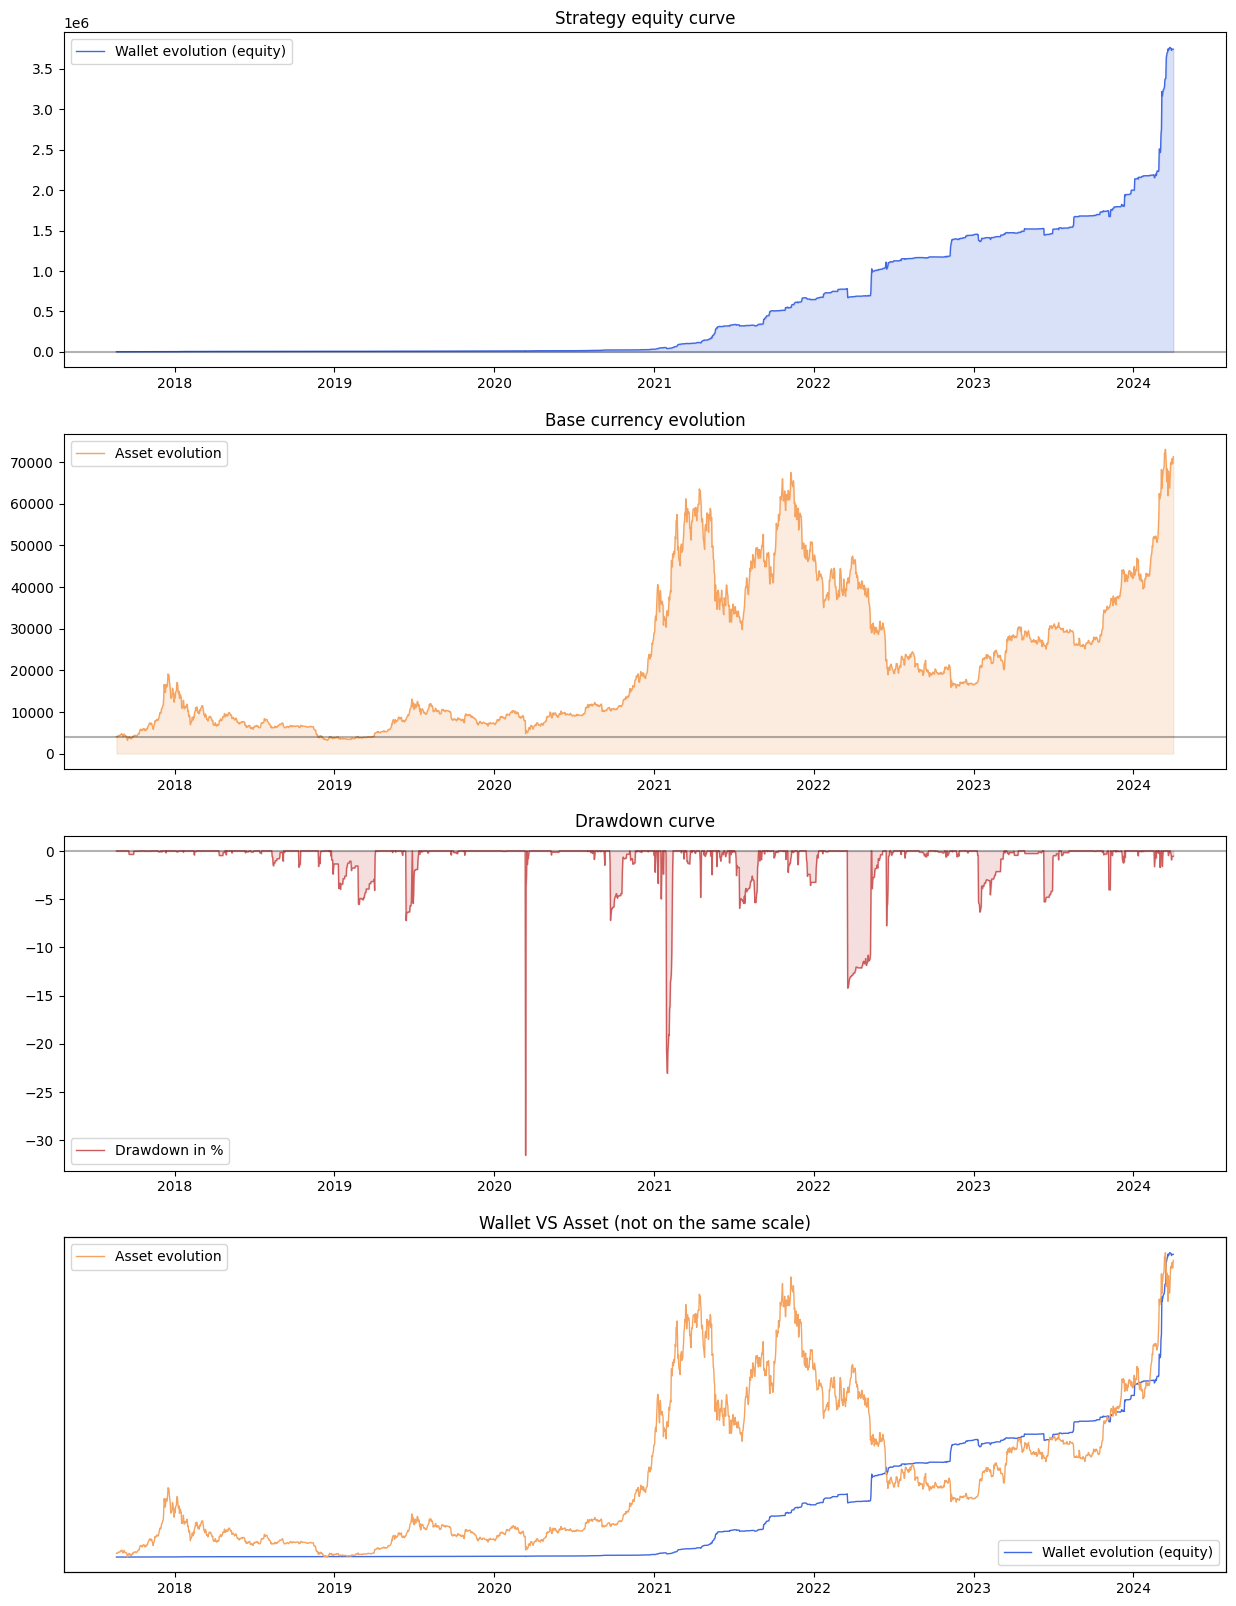

In [6]:
plot_equity_vs_asset(df_days=df_days.loc[:])

----- 2017 Cumulative Performances: 176.04% -----


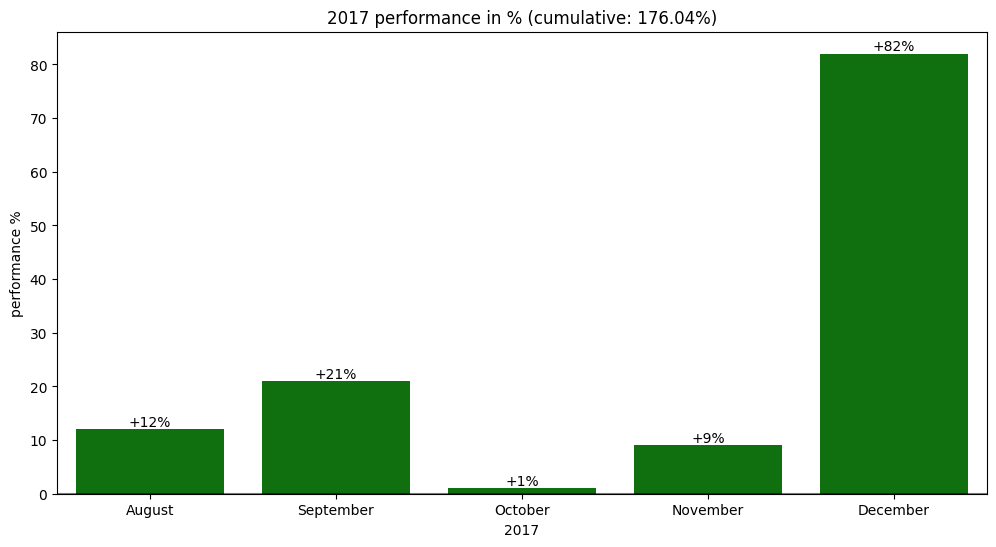

----- 2018 Cumulative Performances: 148.64% -----


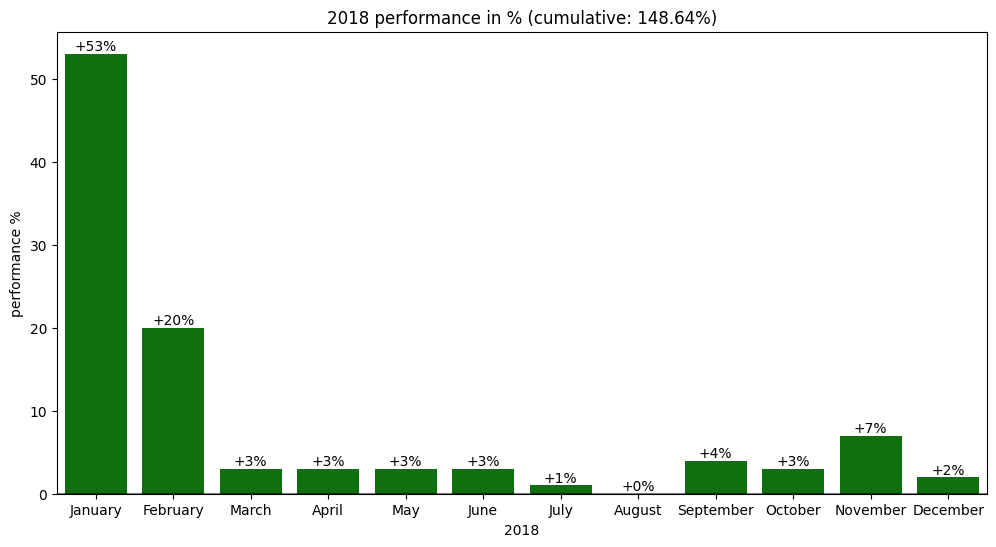

----- 2019 Cumulative Performances: 47.5% -----


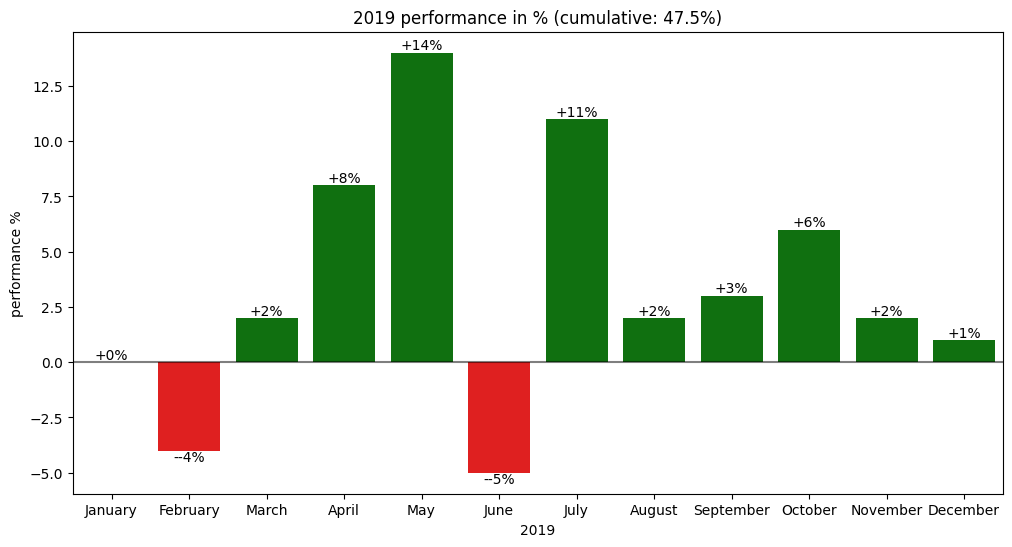

----- 2020 Cumulative Performances: 224.28% -----


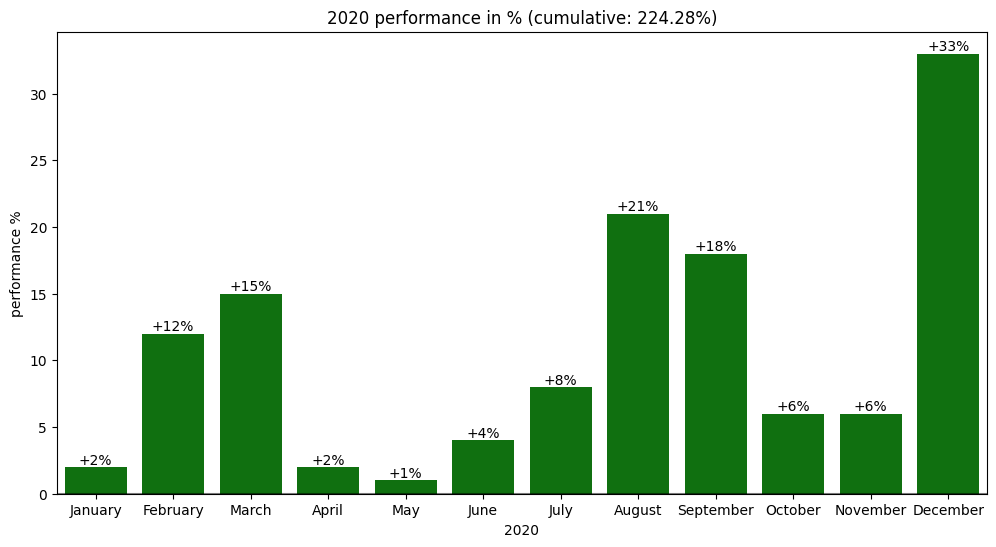

----- 2021 Cumulative Performances: 1876.03% -----


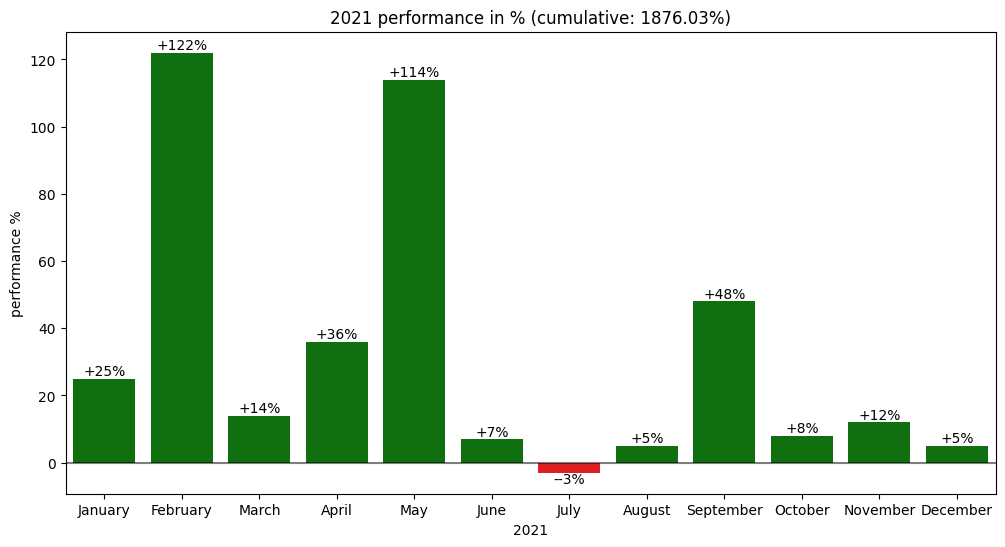

----- 2022 Cumulative Performances: 123.59% -----


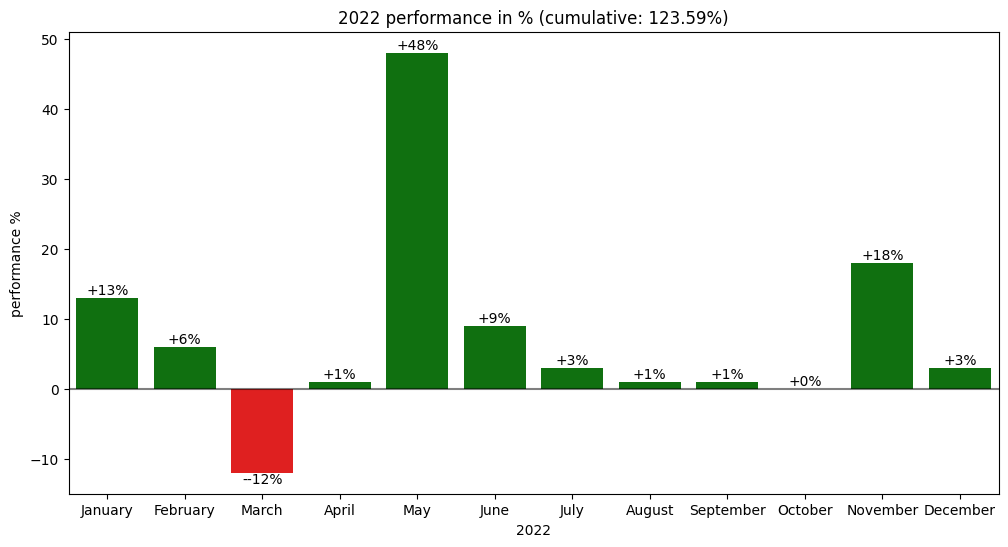

----- 2023 Cumulative Performances: 38.19% -----


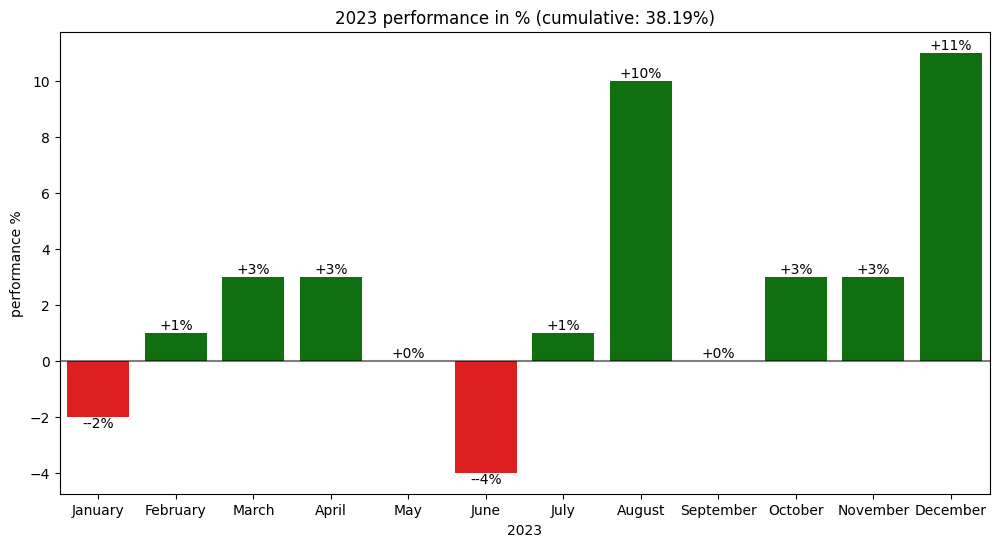

----- 2024 Cumulative Performances: 87.24% -----


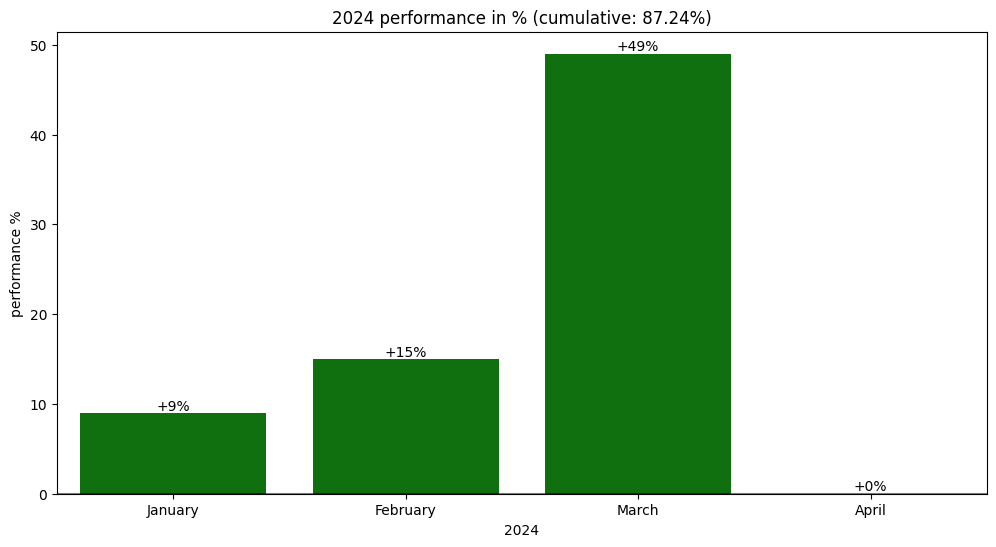

In [7]:
plot_bar_by_month(df_days=df_days)

In [8]:
df_trades

pair           open_date          close_date  \
open_date                                                                     
2017-08-21 06:00:00   ETH/USDT:USDT 2017-08-21 06:00:00 2017-08-21 09:00:00   
2017-08-22 03:00:00   ETH/USDT:USDT 2017-08-22 03:00:00 2017-08-22 05:00:00   
2017-08-22 01:00:00   BTC/USDT:USDT 2017-08-22 01:00:00 2017-08-22 06:00:00   
2017-09-02 05:00:00   ETH/USDT:USDT 2017-09-02 05:00:00 2017-09-02 07:00:00   
2017-09-02 05:00:00   BTC/USDT:USDT 2017-09-02 05:00:00 2017-09-02 07:00:00   
...                             ...                 ...                 ...   
2024-04-01 05:00:00   ICP/USDT:USDT 2024-04-01 05:00:00 2024-04-01 07:00:00   
2024-04-01 05:00:00  PEPE/USDT:USDT 2024-04-01 05:00:00 2024-04-01 09:00:00   
2024-04-01 05:00:00  DOGE/USDT:USDT 2024-04-01 05:00:00 2024-04-01 10:00:00   
2024-04-01 05:00:00  SAND/USDT:USDT 2024-04-01 05:00:00 2024-04-01 11:00:00   
2024-04-01 05:00:00   ENJ/USDT:USDT 2024-04-01 05:00:00 2024-04-01 12:00:00   

                    position      open_reason close_reason   open_price  \
open_date                                                                 
2017-08-21 06:00:00    SHORT  Limit Envelop 1       Market   325.578800   
2017-08-22 03:00:00     LONG  Limit Envelop 3       Market   241.775623   
2017-08-22 01:00:00     LONG  Limit Envelop 2       Market  3605.419863   
2017-09-02 05:00:00     LONG  Limit Envelop 1       Market   356.327640   
2017-09-02 05:00:00     LONG  Limit Envelop 1       Market  4506.268500   
...                      ...              ...          ...          ...   
2024-04-01 05:00:00     LONG  Limit Envelop 1       Market    17.426154   
2024-04-01 05:00:00     LONG  Limit Envelop 2       Market     0.000008   
2024-04-01 05:00:00     LONG  Limit Envelop 2       Market     0.198436   
2024-04-01 05:00:00     LONG  Limit Envelop 1       Market     0.652507   
2024-04-01 05:00:00     LONG  Limit Envelop 1       Market     0.467585   

                     close_price   open_fee  close_fee  open_trade_size  \
open_date                                                                 
2017-08-21 06:00:00   315.394000   0.026667   0.082486       133.306667   
2017-08-22 03:00:00   302.600000   0.080321   0.100507       401.522646   
2017-08-22 01:00:00  3763.737143   0.053547   0.055887       267.681764   
2017-09-02 05:00:00   370.432000   0.029774   0.030946       148.837906   
2017-09-02 05:00:00  4772.837143   0.029774   0.031529       148.841875   
...                          ...        ...        ...              ...   
2024-04-01 05:00:00    18.261400  37.438549  39.225154    187155.305262   
2024-04-01 05:00:00     0.000008  74.872979  78.342160    374290.023909   
2024-04-01 05:00:00     0.204598  74.875226  77.184626    374301.252834   
2024-04-01 05:00:00     0.664800  37.438174  38.135891    187153.433709   
2024-04-01 05:00:00     0.473200  37.437051  37.879005    187147.819162   

                     close_trade_size        wallet  trade_result  \
open_date                                                           
2017-08-21 06:00:00        137.476784  1.004061e+03      4.143450   
2017-08-22 03:00:00        502.535164  1.104839e+03    100.932198   
2017-08-22 01:00:00        279.435915  1.116537e+03     11.700604   
2017-09-02 05:00:00        154.729291  1.122338e+03      5.861612   
2017-09-02 05:00:00        157.646627  1.131111e+03      8.774978   
...                               ...           ...           ...   
2024-04-01 05:00:00     196125.771155  3.752524e+06   8933.027344   
2024-04-01 05:00:00     391710.800316  3.769866e+06  17345.903427   
2024-04-01 05:00:00     385923.127908  3.781411e+06  11546.999848   
2024-04-01 05:00:00     190679.454782  3.784899e+06   3488.582899   
2024-04-01 05:00:00     189395.023941  3.787108e+06   2209.767728   

                     trade_result_pct  trade_result_pct_wallet  \
open_date                                                        
2017-08-21 06:00:00  

In [9]:
wallet_sum = df_trades.groupby('pair')['trade_result'].sum()
print(wallet_sum)

date_trade = df_trades.groupby('close_date')
date_trade


pair
ADA/USDT:USDT      303307.971896
APE/USDT:USDT      258151.275706
AVAX/USDT:USDT     522923.431162
BTC/USDT:USDT      179526.823804
CRV/USDT:USDT       59188.288538
DOGE/USDT:USDT     296650.431584
EGLD/USDT:USDT     159739.680351
ENJ/USDT:USDT      123663.852716
ETH/USDT:USDT      285806.324740
FET/USDT:USDT      185995.838704
ICP/USDT:USDT       41579.391769
IMX/USDT:USDT       80904.982089
KSM/USDT:USDT       59227.921063
LDO/USDT:USDT       78246.331909
LINK/USDT:USDT     181111.810597
LTC/USDT:USDT       97401.256044
MAGIC/USDT:USDT     79155.479995
OCEAN/USDT:USDT     90025.574653
PEPE/USDT:USDT     217286.925730
SAND/USDT:USDT     256994.748141
SOL/USDT:USDT      247248.506494
TRX/USDT:USDT       61853.044866
Name: trade_result, dtype: float64


In [10]:

average_trades_per_day = bt_result['trades'].groupby(bt_result['trades']['open_date'].dt.date).size().mean()
print(average_trades_per_day)

print(df_trades.loc[df_trades['open_reason'] == 'Limit Envelop 1'].size)
print(df_trades.loc[df_trades['open_reason'] == 'Limit Envelop 2'].size)
print(df_trades.loc[df_trades['open_reason'] == 'Limit Envelop 3'].size)

limit_envelop_1_sum = df_trades[df_trades['open_reason'] == 'Limit Envelop 1']['trade_result'].sum()
limit_envelop_2_sum = df_trades[df_trades['open_reason'] == 'Limit Envelop 2']['trade_result'].sum()
limit_envelop_3_sum = df_trades[df_trades['open_reason'] == 'Limit Envelop 3']['trade_result'].sum()

limit_envelop_sums = {
    'Limit Envelop 1': limit_envelop_1_sum,
    'Limit Envelop 2': limit_envelop_2_sum,
    'Limit Envelop 3': limit_envelop_3_sum
}

total_trades = bt_result['total_trades']
print(total_trades)


print(limit_envelop_1_sum)
print(limit_envelop_2_sum)
print(limit_envelop_3_sum)

eth_pair = 'ETH/USDT:USDT'
eth_df = df_list[eth_pair]








4.006499535747446
53280
22500
6160
4315
2104964.1311525535
1372464.819418608
313177.1995489535


In [11]:
#I want the lowest trade_result_pct and the date at which it happened
lowest_trade_result = df_trades['trade_result'].min()
print(lowest_trade_result)
lowest_trade_result_date = df_trades.loc[df_trades['trade_result'] == lowest_trade_result]['close_date']
print(lowest_trade_result_date)


-114087.45915416579
open_date
2022-03-18   2022-03-18 08:00:00
Name: close_date, dtype: datetime64[ns]


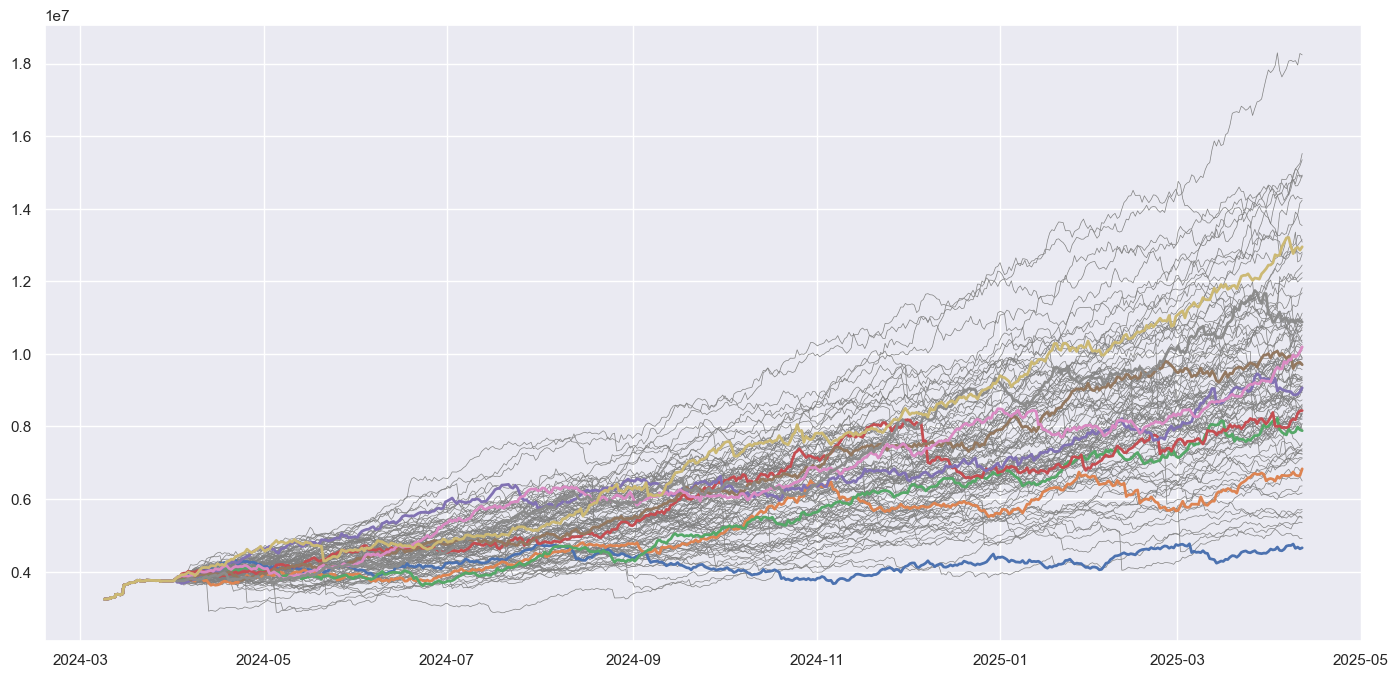

In [12]:
plot_futur_simulations(
    df_trades=df_trades,
    trades_multiplier=3,
    trades_to_forecast=500,
    number_of_simulations=100,
    true_trades_to_show=100,
    show_all_simulations=True,
)

In [13]:
from lightweight_charts import Chart
from lightweight_charts import JupyterChart
pair = "BTC/USDT:USDT"

if "2023-03" in df_list[pair].index:
    dt = df_list[pair].copy().loc["2023-03"]
    dt_trades = df_trades.copy().loc["2023-03"]
    dt_trades = dt_trades.loc[dt_trades["pair"] == pair]
    chart = JupyterChart(width=900, height=400)

    dt["time"] = dt.index
    chart.set(dt)

    lines = ["ma_base"]
    for i in range(1, len(params[pair]["envelopes"]) + 1):
        lines.append(f"ma_low_{i}")
        lines.append(f"ma_high_{i}")
    for line in lines:
        line_object = chart.create_line(line, width=1)
        line_data = pd.DataFrame({"time": dt.index, line: dt[line]})
        line_object.set(line_data)
else:
    print("Specified date '2023-11' does not exist in the dataframe.")

def place_buy_order(key):
    print(f'Buy {key} shares.')

for trades in dt_trades.iterrows():
    if trades[1]['position'] == "LONG":
        chart.marker(time=trades[1]['open_date'], position="below", shape="arrow_up", color="green", text="Long")
        chart.marker(time=trades[1]['close_date'], position="above", shape="arrow_down", color="white", text=trades[1]["close_reason"])
    elif trades[1]['position'] == "SHORT":
        chart.marker(time=trades[1]['open_date'], position="above", shape="arrow_down", color="red", text="Short")
        chart.marker(time=trades[1]['close_date'], position="below", shape="arrow_up", color="white", text=trades[1]["close_reason"])

# chart.show(block=True)
chart.load()

